In [16]:
#if biopython isn't installed:
!conda install -c conda-forge biopython -y

Solving environment: done

## Package Plan ##

  environment location: /home/dylan/miniconda3/envs/qiime2-2021.2

  added / updated specs:
    - biopython


The following NEW packages will be INSTALLED:

  biopython          conda-forge/linux-64::biopython-1.78-py36h8f6f2f9_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [1]:
#this workflow will compare annotations of sequences from the sponge
#microbiome project using the latest q2 silva release, and a custom
#silva taxonomy with additional mitochondrial sequences

In [1]:
import os
import tempfile
import pandas as pd
import seaborn as sns

 
from qiime2 import Artifact
from qiime2.metadata import Metadata
from qiime2.plugins.feature_classifier.methods import extract_reads
from qiime2.plugins.feature_table.methods import merge, merge_seqs, merge_taxa, relative_frequency
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.feature_classifier.methods import classify_consensus_vsearch
from qiime2.plugins.taxa.visualizers import barplot
from qiime2 import Visualization

from scipy import stats

%matplotlib inline
working_dir = os.path.abspath('../')

In [12]:
#set up taxonomies
#manually downloaded: https://data.qiime2.org/2021.2/common/silva-138-99-seqs-515-806.qza
#manually downloaded: https://data.qiime2.org/2021.2/common/silva-138-99-tax-515-806.qza
#manually extracted data files from both

In [36]:
#construct supplemented taxonomy/sequence files
silva_taxonomy_path = working_dir + '/input/taxonomy.tsv'
silva_sequences_path = working_dir + '/input/dna-sequences.fasta'
m2_path = working_dir + '/input/metaxa2.fasta'
extended_taxonomy_path = working_dir + '/input/extended_taxonomy.tsv'
extended_sequences_path = working_dir + '/input/extended_sequences.fasta'

#extract mitochondrial sequences from m2
with open(extended_taxonomy_path, 'w') as extended_taxonomy:
    extended_taxonomy.write('Feature ID\tTaxon\n')
    with open(extended_sequences_path, 'w') as extended_sequences:
        for i, entry in enumerate(SeqIO.parse(m2_path, 'fasta')):
            if 'mitochondria' in entry.description or 'Mitochondria' in entry.description:
                extended_sequences.write('>metaxa2_' + str(i) + '\n')
                extended_sequences.write(str(entry.seq + '\n'))
                specific_info = str(entry.description).split(';')[-1]
                extended_taxonomy.write('metaxa2_' + str(i) + '\td__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Mitochondria; g__Mitochondria; s__' + specific_info + '\n')

In [30]:
#generate 515f-806r reads of m2
#https://forum.qiime2.org/t/processing-filtering-and-evaluating-the-silva-database-and-other-reference-sequence-data-with-rescript/15494
#import to q2
m2_seqs = Artifact.import_data('FeatureData[Sequence]', extended_sequences_path)

#extract v4
v4_m2_seqs, = extract_reads(m2_seqs, 'GTGYCAGCMGCCGCGGTAA', 'GGACTACNVGGGTWTCTAAT', n_jobs = 4, read_orientation = 'forward')

#merge with silva
extended_sequences, = merge_seqs([v4_m2_seqs, Artifact.load(working_dir + '/input/silva-138-99-seqs-515-806.qza')])

#export
extended_sequences.save(working_dir + '/input/extended_sequences.qza')

'/mnt/c/Users/dsone/Documents/zaneveld/smp/input/extended_sequences.qza'

In [37]:
#merge taxonomy files
m2_taxonomy = Artifact.import_data('FeatureData[Taxonomy]', working_dir + '/input/extended_taxonomy.tsv')
extended_taxonomy, = merge_taxa([m2_taxonomy, Artifact.load(working_dir + '/input/silva-138-99-tax-515-806.qza')])
extended_taxonomy.save(working_dir + '/input/extended_taxonomy.qza')

'/mnt/c/Users/dsone/Documents/zaneveld/smp/input/extended_taxonomy.qza'

In [9]:
#smp has nine different biom tables and nine different fasta files
#these were manually downloaded from qiita and must be merged, which is
#easier to do in q2, after importing
file_ids = [56699, 57025, 61467, 61513, 61542, 61905, 61906, 61948, 62042]
fts = []
sequences = []
for file_id in file_ids:
    biom_path = working_dir + '/input/' + str(file_id) + '_all.biom'
    fasta_path = working_dir + '/input/' + str(file_id) + '_all.seqs.fa'
    ft = Artifact.import_data('FeatureTable[Frequency]', biom_path, 'BIOMV210Format')
    fts.append(ft)
    seqs = Artifact.import_data('FeatureData[Sequence]', fasta_path)
    sequences.append(seqs)
ft, = merge(fts)
ft.save(working_dir + '/input/ft.qza')
seqs, = merge_seqs(sequences)
seqs.save(working_dir + '/input/seqs.qza')

'/mnt/c/Users/dsone/Documents/zaneveld/smp/input/seqs.qza'

In [11]:
sequence_path = working_dir + '/input/seqs.qza'
seqs = Artifact.load(sequence_path)
silva_seqs = Artifact.load(working_dir + '/input/silva-138-99-seqs-515-806.qza')
silva_taxonomy = Artifact.load(working_dir + '/input/silva-138-99-tax-515-806.qza')
extended_seqs = Artifact.load(working_dir + '/input/extended_sequences.qza')
extended_taxonomy = Artifact.load(working_dir + '/input/extended_taxonomy.qza')
silva_classification_taxonomy, = classify_consensus_vsearch(seqs,
                                                           silva_seqs,
                                                           silva_taxonomy,
                                                           threads = 8)
silva_classification_taxonomy.save(working_dir + '/output/silva_smp_classification_taxonomy.qza')
extended_classification_taxonomy, = classify_consensus_vsearch(seqs,
                                                              extended_seqs,
                                                              extended_taxonomy,
                                                              threads = 8)
extended_classification_taxonomy.save(working_dir + '/output/extended_smp_classification_taxonomy.qza')

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-bw7td2gt/509ab548-a28d-42de-862d-3b5a6726a4fe/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-udmr3xg9/b41681fb-a4e7-4ef8-a23a-a26f1bcfd272/data/dna-sequences.fasta --threads 8 --output_no_hits --blast6out /tmp/tmpxphbf23j

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-bw7td2gt/509ab548-a28d-42de-862d-3b5a6726a4fe/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp

'/mnt/c/Users/dsone/Documents/zaneveld/smp/output/extended_smp_classification_taxonomy.qza'

In [4]:
#get a sampleID column
#first, summarize the ft to get rid of biom format
ft = Artifact.load(working_dir + '/output/smp_ft.qza')
metadata = Metadata.load(working_dir + '/input/sample_information_from_prep_1257.tsv')
summary, = summarize(ft, metadata = metadata)
summary.save(working_dir + '/output/summary.qzv')

MetadataFileError: There was an issue with loading the metadata file:

Metadata IDs must be unique. The following IDs are duplicated: '10346.1', '10346.11', '10346.12', '10346.2', '10346.3', '10346.4', '10346.5', '10346.6'

There may be more errors present in the metadata file. To get a full report, sample/feature metadata files can be validated with Keemei: https://keemei.qiime2.org

Find details on QIIME 2 metadata requirements here: https://docs.qiime2.org/2021.2/tutorials/metadata/

In [ ]:
with tempfile.TemporaryDirectory() as temp_dir:
    summary.export_data(temp_dir)
    with open(temp_dir + '/sample-frequency-detail.csv') as infile:
        next(infile)
        with open(working_dir + '/input/metadata.tsv', 'w') as md_file:
            md_file.write('#SampleID\n')
            for line in infile:
                sample_id = line.split(',')[0]
                md_file.write(sample_id + '\n')

In [4]:
#i don't have metadata for this, but it's not really necessary. all
#that's needed is a column with sample names, which I pulled from the
#feature table summary qzv (manually)
metadata = Metadata.load(working_dir + '/input/sample_information_from_prep_1257.tsv')
references = ['silva', 'extended']
for reference in references:
    taxonomy_path = working_dir + '/output/' + reference + '_smp_classification_taxonomy.qza'
    taxonomy = Artifact.load(taxonomy_path)
    ft = Artifact.load(working_dir + '/input/ft.qza')
    tbp, = barplot(ft, taxonomy, metadata)
    tbp.save(working_dir + '/output/' + reference + '_smp_tbp.qzv')

In [5]:
proportion_unassigned = []
references1 = []
proportion_mitochondria = []
references5 = []
for reference in references:
    with tempfile.TemporaryDirectory() as temp_dir:
        tbp_path = working_dir + '/output/' + reference + '_smp_tbp.qzv'
        tbp = Visualization.load(tbp_path)
        tbp.export_data(temp_dir)
        df1= pd.read_csv(temp_dir + '/level-1.csv')
        df1['total'] = df1.sum(axis = 1)
        df1['reference'] = reference
        proportion_unassigned.extend(list(df1['Unassigned'] / df1['total']))
        references1.extend(list(df1['reference']))
        df5 = pd.read_csv(temp_dir + '/level-5.csv')
        df5['total'] = df5.sum(axis = 1)
        df5['reference'] = reference
        proportion_mitochondria.extend(list(df5['d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria'] / df5['total']))
        references5.extend(list(df5['reference']))

In [6]:
lvl1 = list(zip(proportion_unassigned, references1))
lvl1_df = pd.DataFrame(lvl1, columns = ['proportion unassigned', 'reference taxonomy'])
lvl1_df.to_csv(working_dir + '/output/lvl1.csv', index = False)

In [7]:
lvl5 = list(zip(proportion_mitochondria, references5))
lvl5_df = pd.DataFrame(lvl5, columns = ['proportion mitochondria', 'reference taxonomy'])
lvl5_df.to_csv(working_dir + '/output/lvl5.csv', index = False)

In [8]:
from IPython.core.display import display
print("Proportion Unassigned")
display(lvl1_df)
print("Proportion Mitochondria")
display(lvl5_df)

Proportion Unassigned


,proportion unassigned,reference taxonomy
0,0.002137,silva
1,0.036866,silva
2,0.002752,silva
3,0.001804,silva
4,0.005135,silva
...,...,...
7653,0.543374,extended
7654,0.474205,extended
7655,0.112090,extended
7656,0.061690,extended


Proportion Mitochondria


,proportion mitochondria,reference taxonomy
0,0.000131,silva
1,0.000000,silva
2,0.000000,silva
3,0.002727,silva
4,0.000297,silva
...,...,...
7653,0.000000,extended
7654,0.005016,extended
7655,0.000244,extended
7656,0.002223,extended


/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 10.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


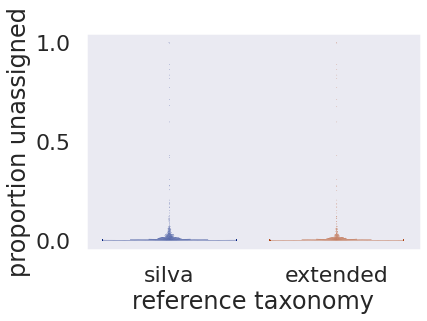

In [57]:
sns.set_style("dark")
sns.set_context("poster")

g = sns.swarmplot(x = "reference taxonomy", dodge = True,
                  y = "proportion unassigned",
                  size = 0.5, data = lvl1_df, palette = "dark")

/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 54.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 20.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


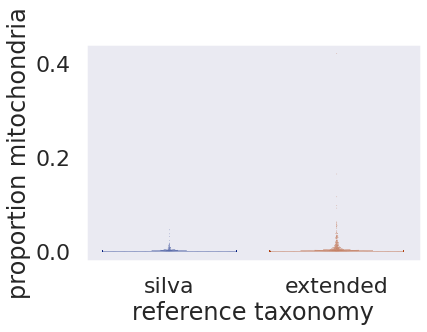

In [58]:
h = sns.swarmplot(x = 'reference taxonomy', dodge = True,
                 y = 'proportion mitochondria',
                 size = 0.5, data = lvl5_df, palette = 'dark')

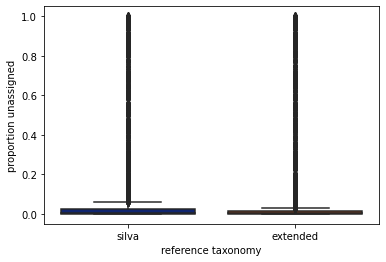

In [11]:
g = sns.boxplot(x = 'reference taxonomy', y = 'proportion unassigned',
               data = lvl1_df, palette = 'dark')

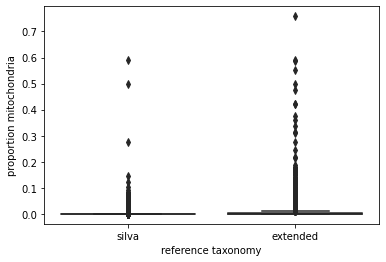

In [12]:
h = sns.boxplot(x = 'reference taxonomy', y = 'proportion mitochondria',
               data = lvl5_df, palette = 'dark')

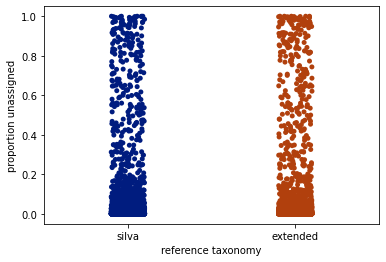

In [9]:
i = sns.stripplot(x = 'reference taxonomy', y = 'proportion unassigned',
                 data = lvl1_df, palette = 'dark')

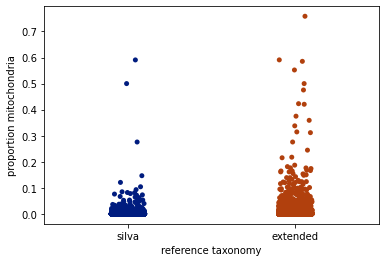

In [10]:
j = sns.stripplot(x = 'reference taxonomy', y = 'proportion mitochondria',
                 data = lvl5_df, palette = 'dark')

In [69]:
lvl5_df

,proportion mitochondria,reference taxonomy
0,0.000359,silva
1,0.004853,silva
2,0.000054,silva
3,0.000107,silva
4,0.000000,silva
...,...,...
1837,0.014065,extended
1838,0.002947,extended
1839,0.001094,extended
1840,0.000595,extended


In [13]:
silva = lvl5_df[lvl5_df['reference taxonomy']=='silva']
extended = lvl5_df[lvl5_df['reference taxonomy']=='extended']
u, p = stats.mannwhitneyu(silva['proportion mitochondria'], extended['proportion mitochondria'])

In [14]:
u

3856227.5

In [15]:
p

1.1956084234717965e-292